# Imports

In [1]:
import db_connection as db
import numpy as np
import pandas as pd
from pandas import DataFrame
from google.cloud import bigquery
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, InputLayer
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt

It is important to create a "settings.ini" file that will contain the necessary parameters (database config parameters, in this case) for the "cfg.py" script. The format of this file will be:
<br>
<br>
[settings]<br>
DB_PASS=example_pass<br>
DB_USER=postgres<br>
DB_NAME=postgres<br>
DB_HOST=127.0.0.1<br>
DB_PORT=5432<br>
<br>
This is the configuration that a local postgreSQL database needs in order to create a connection with python 3. Note that this is a standard configuration and details may vary depending on the configuration of your own database.

# Functions definition

## PHASE 1: ETL

First, we need to set the client that will be used to get data from BigQuery. In this case, we created a .json key from our Google Cloud project and downloaded it to use it in our "src/" repository folder:

In [2]:
# Google Cloud BigQuery client for extracting raw data
client = bigquery.Client()

Next, we will define our 3 steps for data gathering:<br>

- <strong>extract</strong>: step that contains the query which extracts raw information from our chosen dataset.
- <strong>transform</strong>: step that cleans the retrieved data from previous step. In this case, 5 columns that the own code describes.
- <strong>load</strong>: step that loads the clean data in our database. <em>Note</em> that between this step and the previous one we will train our neural network in order to save our prediction.

In [3]:
def extract():
    query = "SELECT * FROM `housecanary-com.sample.zip_ts` LIMIT 2000"

    query_job = client.query(query)

    return query_job


def transform(data_raw):
    '''
    columns that will be saved (from 'zip_ts' table from dataset ):
        - zip (string): 5 digit postal code
        - msa (string): 5 digit Metropolitan Statistical Area code
        - month (date): timeseries date
        - hpi_value (float): nominal housing price index
        - hpi_real (float): real housing price index after adjusting nominal hpi for inflation as measured by the CPI
    '''

    # Selecting desired columns and saving them in a list for filtering next
    selected_columns = ['zip', 'msa', 'month', 'hpi_value', 'hpi_real']

    # Getting DataFrame from previous query result
    df_clean = data_raw.to_dataframe()

    # Filtering columns given selected columns list
    df_clean: DataFrame = df_clean.loc[:, selected_columns]

    # Converting zip and msa columns to float values, month to datetime
    df_clean['zip'] = df_clean['zip'].astype(float)
    df_clean['msa'] = df_clean['msa'].astype(float)
    df_clean['month'] = pd.to_datetime(df_clean['month'])

    # Cleaning data from NaN values in hpi_value and hpi_real
    df_clean = df_clean[df_clean.hpi_value.notnull()]
    df_clean = df_clean[df_clean.hpi_real.notnull()]

    return df_clean


def load(df, table_name):
    # Table and Schema
    schema_name = "public"
    
    db.insert_rows(df, table_name, schema_name)

## PHASE 2: AI training

In this phase, we will create a tensorflow model that will use the retrieved and cleaned data from previous our ETL phase.

In [4]:
# Retrieving raw data from Google Cloud Platform dataset (House-canary)
data_raw = extract()

# Transforming raw data into processed data for database
data_processed = transform(data_raw)

In [5]:
# Loading dataset into our raw_data table from our PostgreSQL Database
load(data_processed, table_name = "zip_ts_raw")

In [5]:
# Sort values by its date and setting the column as index
data_processed = data_processed.sort_values(by=['month'])
data_processed.set_index('month', drop=False, inplace=True)

In [6]:
# Getting df dates for future indexing
df_dates = data_processed['month'].drop_duplicates()
df_dates

month
1975-01-01   1975-01-01
1975-02-01   1975-02-01
1975-03-01   1975-03-01
1975-04-01   1975-04-01
1975-05-01   1975-05-01
                ...    
2021-09-01   2021-09-01
2021-10-01   2021-10-01
2021-11-01   2021-11-01
2021-12-01   2021-12-01
2022-01-01   2022-01-01
Name: month, Length: 565, dtype: datetime64[ns]

In [7]:
# Showing dataframe
data_processed

,zip,msa,month,hpi_value,hpi_real
month,,,,,
1975-01-01,94598.0,41860.0,1975-01-01,12.366224,41.283799
1975-02-01,94114.0,41860.0,1975-02-01,7.942476,26.364190
1975-02-01,94598.0,41860.0,1975-02-01,12.394297,41.141526
1975-03-01,94114.0,41860.0,1975-03-01,7.945606,26.274676
1975-03-01,94598.0,41860.0,1975-03-01,12.506154,41.355578
...,...,...,...,...,...
2021-12-01,94598.0,41860.0,2021-12-01,279.995433,181.742295
2021-12-01,94102.0,41860.0,2021-12-01,342.150567,222.086584
2022-01-01,94114.0,41860.0,2022-01-01,249.625375,161.749015


In [8]:
# Divide data in features (X) and labels (y)
# In this section, we will predict the 6th value per 5 values
# Example: input [1,2,3,4,5] -> output [6]
WINDOW_SIZE = 5

# Here, if I use this commented line instead of the next one, the training loss will be much worse (I suspect it is because they're constants)
df_as_np_input = data_processed.drop(['month', 'zip', 'msa'], axis=1).to_numpy()

df_as_np_output = data_processed[['hpi_value', 'hpi_real']].to_numpy()

X = []
y = []

for i in range(len(df_as_np_input)-WINDOW_SIZE):
    row = [a for a in df_as_np_input[i:i+5]]
    X.append(row)

    label = df_as_np_output[i+5]
    y.append(label)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1687, 5, 2), (1687, 2))

In [9]:
### Divide data in test and train sets

# Training data
X_train, y_train = X[:1200], y[:1200]

# Validation data
X_val, y_val = X[1200:1400], y[1200:1400]

# Test data
X_test, y_test = X[1400:], y[1400:]

# Showing values
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1200, 5, 2), (1200, 2), (200, 5, 2), (200, 2), (287, 5, 2), (287, 2))

In [116]:
# Define neural network architecture (GRU layer)
model_gru = Sequential()
model_gru.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64))
model_gru.add(Dense(8, activation='relu'))
model_gru.add(Dense(2, activation='linear'))

# Define neural network architecture (LSTM layer)
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])), # Input shape as parameter
    LSTM(64),
    Dense(8, activation='relu'),
    Dense(2, activation='linear')  # 2 output neurons to predict 2 columns
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=[RootMeanSquaredError()])
model_gru.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=[RootMeanSquaredError()])

In [117]:
# Train model
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val))
history_gru = model_gru.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
38/38 [==============================] - 1s 7ms/step - loss: 6930.9526 - root_mean_squared_error: 83.2523 - val_loss: 14084.1709 - val_root_mean_squared_error: 118.6768
Epoch 2/150
38/38 [==============================] - 0s 2ms/step - loss: 6814.1582 - root_mean_squared_error: 82.5479 - val_loss: 13903.6055 - val_root_mean_squared_error: 117.9136
Epoch 3/150
38/38 [==============================] - 0s 2ms/step - loss: 6627.8071 - root_mean_squared_error: 81.4114 - val_loss: 13581.1787 - val_root_mean_squared_error: 116.5383
Epoch 4/150
38/38 [==============================] - 0s 2ms/step - loss: 6331.0581 - root_mean_squared_error: 79.5679 - val_loss: 13004.6826 - val_root_mean_squared_error: 114.0381
Epoch 5/150
38/38 [==============================] - 0s 2ms/step - loss: 6001.1953 - root_mean_squared_error: 77.4674 - val_loss: 12539.5186 - val_root_mean_squared_error: 111.9800
Epoch 6/150
38/38 [==============================] - 0s 2ms/step - loss: 5689.8472 - root_mean_

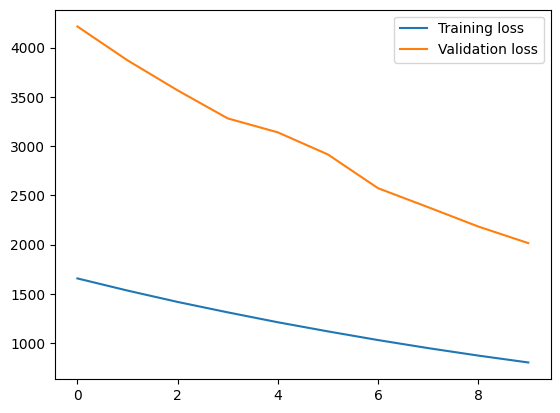

In [118]:
# Showing LSTM model loss in plot
plt.plot(history.history['loss'][20:30], label='Training loss')
plt.plot(history.history['val_loss'][20:30], label='Validation loss')
plt.legend()

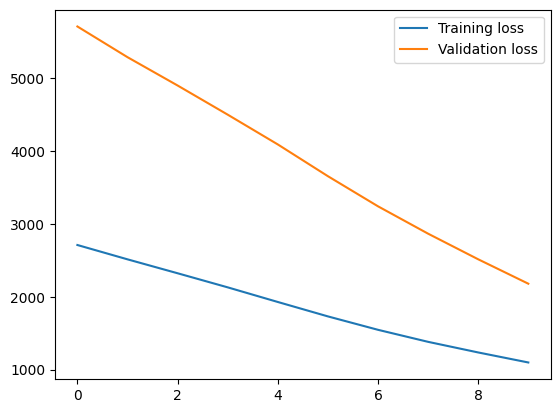

In [119]:
# Showing GRU model loss in plot
plt.plot(history_gru.history['loss'][20:30], label='Training loss')
plt.plot(history_gru.history['val_loss'][20:30], label='Validation loss')
plt.legend()

In [95]:
# Validating models' predictions
train_predictions1 = model.predict(X_train)
train_predictions2 = model_gru.predict(X_train)
train_results = pd.DataFrame(data={'hpi_value_prediction_LSTM': train_predictions1[:, 0],
                                   'hpi_real_prediction_LSTM': train_predictions1[:, 1],
                                   'hpi_value_prediction_GRU': train_predictions2[:, 0],
                                   'hpi_real_prediction_GRU': train_predictions2[:, 1],
                                   'hpi_value': y_train[:, 0],
                                   'hpi_real': y_train[:, 1]})
train_results

38/38 [==============================] - 0s 759us/step


,hpi_value_prediction_LSTM,hpi_real_prediction_LSTM,hpi_value_prediction_GRU,hpi_real_prediction_GRU,hpi_value,hpi_real
0,11.688526,40.735214,9.767306,39.268909,13.768903,45.531258
1,9.730109,38.915298,8.056095,37.467903,12.701623,41.843461
2,9.021523,38.004982,6.862540,36.314762,8.042733,26.495494
3,16.034708,44.661812,14.154643,43.269821,13.820352,45.528933
4,11.834664,41.507885,9.595049,39.587444,13.928677,45.799377
...,...,...,...,...,...,...
1195,139.515884,123.956429,137.473511,123.109848,154.218645,123.821410
1196,140.074509,124.227264,136.833130,122.659058,138.114581,110.891535
1197,136.487961,121.735245,136.795532,122.556282,131.762084,105.791145
1198,138.518768,123.298851,136.827881,122.578758,136.477662,108.800269


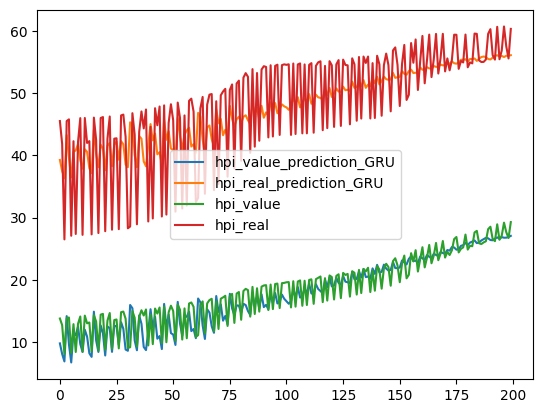

In [96]:
# Showing plot previous results
plt.plot(train_results['hpi_value_prediction_GRU'][:200], label='hpi_value_prediction_GRU')
plt.plot(train_results['hpi_real_prediction_GRU'][:200], label='hpi_real_prediction_GRU')
plt.plot(train_results['hpi_value'][:200], label='hpi_value')
plt.plot(train_results['hpi_real'][:200], label='hpi_real')
plt.legend()

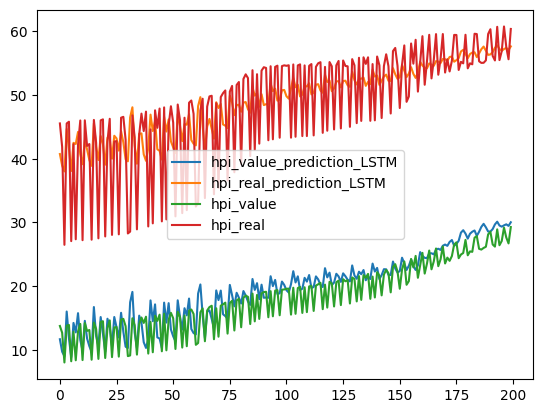

In [97]:
# Showing plot previous results
plt.plot(train_results['hpi_value_prediction_LSTM'][:200], label='hpi_value_prediction_LSTM')
plt.plot(train_results['hpi_real_prediction_LSTM'][:200], label='hpi_real_prediction_LSTM')
plt.plot(train_results['hpi_value'][:200], label='hpi_value')
plt.plot(train_results['hpi_real'][:200], label='hpi_real')
plt.legend()

In [120]:
# Number of rows (1 row per month) to be predict
n_days_to_predict = 36

# Last day (most recent date) from DataFrame
n_last_past_day = df_dates[-1]

# Predicting values with future
future_predictions = model_gru.predict(X[-n_days_to_predict:])
future_predictions_lstm = model.predict(X[-n_days_to_predict:])

2/2 [==============================] - 0s 2ms/step


C:\Users\jhost\AppData\Local\Temp\ipykernel_62476\2693172594.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_last_past_day = df_dates[-1]


2/2 [==============================] - 0s 2ms/step


In [121]:
# Setting new index for predictions dataframe
future_predictions_dates = []

for i in range(n_days_to_predict):
    future_predictions_dates.append(n_last_past_day + pd.DateOffset(months=i))

In [122]:
# Creating new DataFrame for future values
future_predictions_df = pd.DataFrame(index=future_predictions_dates, data={'hpi_value_prediction_GRU': future_predictions[:, 0],
                                           'hpi_real_prediction_GRU': future_predictions[:, 1]})

# Creating new DataFrame for future values
future_predictions_df_lstm = pd.DataFrame(index=future_predictions_dates, data={'hpi_value_prediction_LSTM': future_predictions_lstm[:, 0],
                                           'hpi_real_prediction_LSTM': future_predictions_lstm[:, 1]})

# Setting new Dataframe for only columns that interest us
original_df = pd.DataFrame(data={'hpi_value': data_processed['hpi_value'],
                                 'hpi_real': data_processed['hpi_real']})

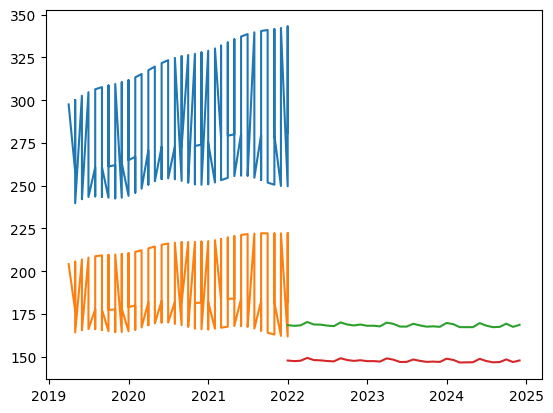

In [101]:
# Showing predictions along with original DataFrame last values
plt.plot(original_df[-100:])
plt.plot(future_predictions_df)

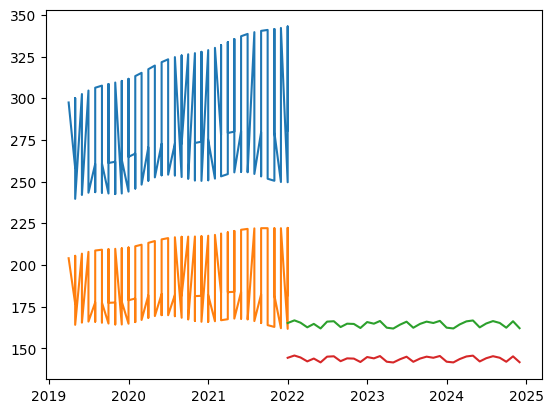

In [123]:
# Showing predictions along with original DataFrame last values
plt.plot(original_df[-100:])
plt.plot(future_predictions_df_lstm)

In [ ]:
# Loading predictions into DataBase
load(future_predictions_df, "zip_ts_processed")